In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN,SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.model_selection import KFold
import pickle
import spacy
from sklearn.ensemble import RandomForestClassifier

In [2]:
# df_train = pd.read_json("Dataset/train.json")
# df_test = pd.read_json("Dataset/test.json")
df_train = pd.read_json("train.json")
df_test = pd.read_json("test.json")
nltk.download('stopwords')
nltk.download('wordnet')

df_train.head(20)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli..."
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo..."
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por..."
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-..."


# Preprocessing

In [ ]:
df_train.describe()

,id
count,39774.000000
mean,24849.536959
std,14360.035505
min,0.000000
25%,12398.250000
50%,24887.000000
75%,37328.500000
max,49717.000000


In [ ]:
df_test.describe()

,id
count,9944.000000
mean,24894.350362
std,14322.958061
min,5.000000
25%,12541.000000
50%,24731.500000
75%,37113.250000
max,49715.000000


In [ ]:
df_train.isna().describe()

,id,cuisine,ingredients
count,39774,39774,39774
unique,1,1,1
top,False,False,False
freq,39774,39774,39774


In [ ]:
df_test.isna().describe()

,id,ingredients
count,9944,9944
unique,1,1
top,False,False
freq,9944,9944


In [ ]:
df_train.isna().sum()

,0
id,0
cuisine,0
ingredients,0


In [ ]:
df_test.isna().sum()

,0
id,0
ingredients,0


Number of Unique Cuisines are:  20


,count
cuisine,
italian,7838
mexican,6438
southern_us,4320
indian,3003
chinese,2673
french,2646
cajun_creole,1546
thai,1539
japanese,1423


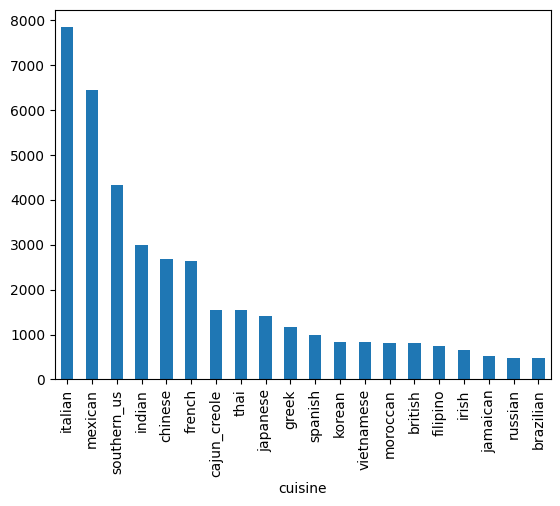

In [ ]:
cuisine_freq = df_train["cuisine"].value_counts()

cuisine_freq.plot(kind="bar")
print("Number of Unique Cuisines are: ",len(cuisine_freq))
cuisine_freq


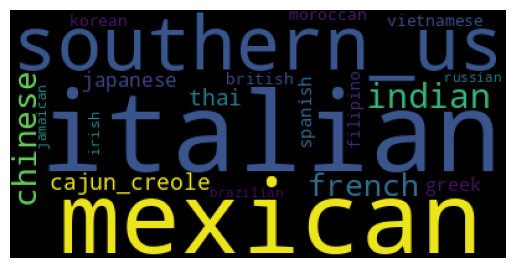

In [ ]:
cuisine_freq_dict = cuisine_freq.to_dict()

wordcloud = WordCloud()
cuisine_wordcloud = wordcloud.generate_from_frequencies(cuisine_freq_dict)
plt.axis('off')
plt.imshow(cuisine_wordcloud)

In [ ]:
ingredients_df = df_train.explode('ingredients')
ingredients_freq = ingredients_df['ingredients'].value_counts()


print("Number of Unique Ingredients are: ",len(ingredients_freq))
ingredients_freq

Number of Unique Ingredients are:  6714


,count
ingredients,
salt,18049
olive oil,7972
onions,7972
water,7457
garlic,7380
...,...
sauerkraut juice,1
no-calorie sweetener,1
Bob Evans Italian Sausage,1


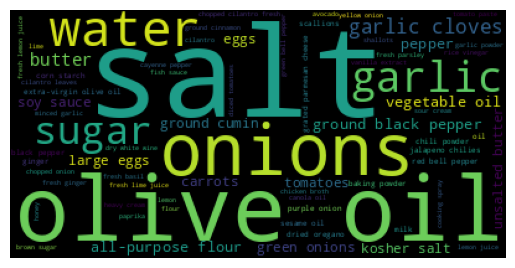

In [ ]:
ingredients_freq_dict = ingredients_freq.to_dict()
ingredients_freq_wordcloud=wordcloud.generate_from_frequencies(ingredients_freq_dict)
plt.axis('off')
plt.imshow(ingredients_freq_wordcloud)

In [ ]:
ingredients_by_cuisine = ingredients_df.groupby('cuisine')

ingredients_by_cuisine_freq = ingredients_by_cuisine['ingredients'].value_counts()

ingredients_by_cuisine_freq

cuisine     ingredients         
brazilian   salt                    194
            onions                  133
            olive oil               118
            lime                     89
            water                    87
                                   ... 
vietnamese  worcestershire sauce      1
            yam bean                  1
            yellow peppers            1
            yellow squash             1
            yukon gold potatoes       1
Name: count, Length: 29179, dtype: int64

In [ ]:

#To do for pre-processing, i think:
#NER: The one from Assignment 1 is missing ingredients: confirm if we need to do NER or no.
#Rank freq all that plots from Assignment 1
#Freq-cuisine stuff from Assignment 2
#Create WordCloud/barplot/any visualisation, to see what ingredients are popular per cuisine - dont know how to use ingredients_by_cuisine_freq for that

In [3]:
def pre_process(ingredient_list):
    stop_words = set(stopwords.words("english"))
    word_lemmatizer = WordNetLemmatizer()
    cooking_words = {"cut","organic","fresh","large","small","diced","chopped","minced","cup","spoon","chop","tablespoon","teaspoon","pinch","boiled","baked","grilled","steamed","sliced","whole","crushed","pureed","roasted","blended","mashed","peeled","shredded","cut","stirred","whisked","seared","toasted","frozen","softened","defrosted","grated","fried","drained","seasoned","marinated","garnished","glazed","caramelized","zested","dressed","broiled","cubed","poured","melted","scrambled","simmered","braised","browned","reduced","cooled","tossed"}
    ingridient_processed = []
    for ingredients in ingredient_list:
        final_ingredient = []
        split_list = ingredients.split(" ")
        for ingredient in split_list:
            ingredient = ingredient.strip()
            ingredient = re.sub(r'[^a-zA-Z\s]','',ingredient)
            if(ingredient in stop_words or ingredient in cooking_words):
#                 print(ingredient)
                continue
            else:

                ingredient = word_lemmatizer.lemmatize(ingredient)
                if(ingredient == ""):
                    continue
                final_ingredient.append(ingredient)
        if(len(final_ingredient) > 0):
            ingridient_processed.append(" ".join(final_ingredient))
#     print(ingridient_processed)
    return " ".join(ingridient_processed)


In [4]:
df_train["ingredients"] = df_train["ingredients"].map(pre_process)
df_test["ingredients"] = df_test["ingredients"].map(pre_process)

In [ ]:
df_train.head()

,id,cuisine,ingredients
0,10259,greek,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,plain flour ground pepper salt tomato ground b...
2,20130,filipino,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,water vegetable oil wheat salt
4,13162,indian,black pepper shallot cornflour cayenne pepper ...


In [ ]:
df_test.head()

,id,ingredients
0,18009,baking powder egg allpurpose flour raisin milk...
1,28583,sugar egg yolk corn starch cream tartar banana...
2,41580,sausage link fennel bulb frond olive oil cuban...
3,29752,meat cut file powder smoked sausage okra shrim...
4,35687,ground black pepper salt sausage casing leek p...


In [5]:
X = df_train["ingredients"]
y = df_train["cuisine"]

le = LabelEncoder()
y = le.fit_transform(y)

tfid = TfidfVectorizer()
X = tfid.fit_transform(X)

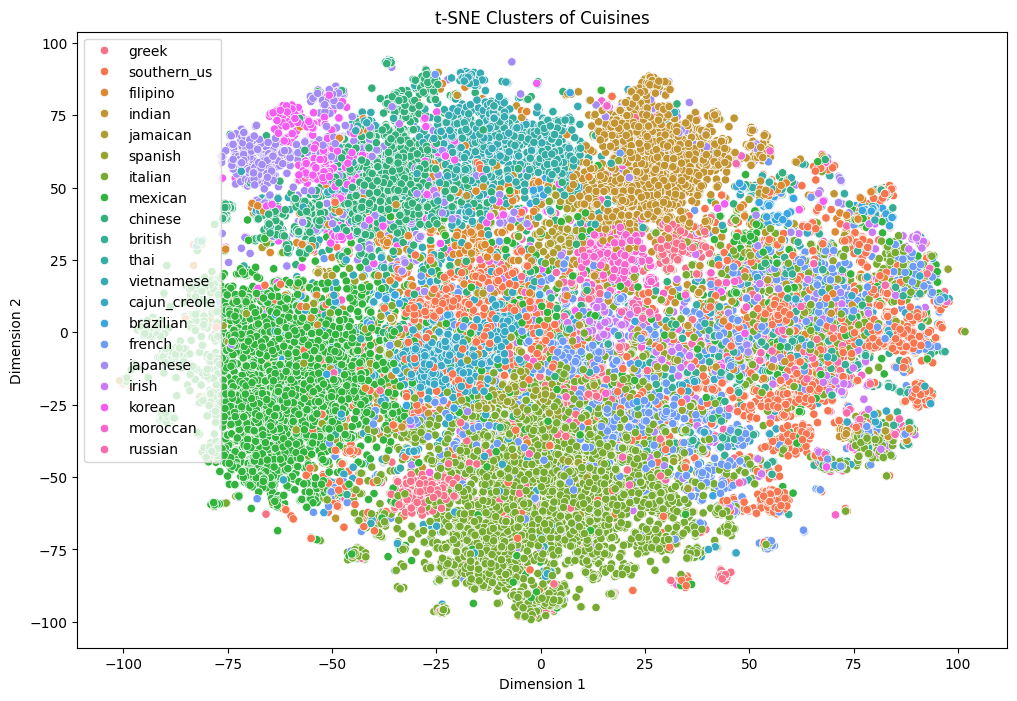

In [ ]:
tsne = TSNE(n_components=2, random_state=42,max_iter=1000)
X_tsne = tsne.fit_transform(X.toarray())

df_tsne = pd.DataFrame(X_tsne, columns=['Dimension 1','Dimension 2'])
df_tsne['Cuisine'] = le.inverse_transform(y)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Dimension 1',y='Dimension 2',hue='Cuisine',data=df_tsne)
plt.title('t-SNE Clusters of Cuisines')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [6]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X.toarray())
X_train_pca,X_test_pca,y_train_pca,y_test_pca = train_test_split(X_pca,y,test_size=0.20,random_state=42)

In [ ]:
svm_model = SVC()
svm_model.fit(X_train_pca,y_train)
y_pred_pca = svm_model.predict(X_test_pca)
print(f"SVM Accuracy : {accuracy_score(y_test,y_pred_pca)}")

ValueError: Found input variables with inconsistent numbers of samples: [29830, 31819]

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)
adaysn = ADASYN()
smote=SMOTE()
unique_elements, counts = np.unique(y_train, return_counts=True)
print(f"Before oversampling : {counts}")
X_train_adasyn,y_train_adasyn = adaysn.fit_resample(X_train,y_train)
X_train_smote,y_train_smote = smote.fit_resample(X_train,y_train)

unique_elements, counts = np.unique(y_train_adasyn, return_counts=True)
print(f"After oversampling : {counts}")

Before oversampling : [ 383  647 1218 2163  619 2096  926 2401  516 6271  435 1139  664 5102
  655  400 3472  807 1224  681]
After oversampling : [6335 6377 6374 6238 6224 6349 6247 6206 6355 6271 6238 6181 6209 5905
 6215 6290 5850 6161 6273 6222]


In [ ]:
svm_model = SVC()
svm_model.fit(X_train_adasyn,y_train_adasyn)
y_pred = svm_model.predict(X_test)
print(f"SVM Accuracy : {accuracy_score(y_test,y_pred)}")

with open('svm_oversmapled_model.pkl','wb') as f:
    pickle.dump(svm_model,f)

In [ ]:
X_pipeline = df_train["ingredients"]
y_pipeline = df_train["cuisine"]

X_pipeline_train,X_pipeline_test,y_pipeline_train,y_pipeline_test = train_test_split(X_pipeline,y_pipeline,test_size=0.2,random_state=42)
# adaysn = ADASYN()
# X_pipeline_adasyn,y_pipeline_adasyn = adaysn.fit_resample(X_pipeline,y_pipeline)
pipeline = make_pipeline(tfid,SVC())
pipeline.fit(X_pipeline_train,y_pipeline_train)
# y_pred_pipeline = pipeline.predict(X_test)
print(f"Pipeline Accuracy : {pipeline.score(X_pipeline_test,y_pipeline_test)}")

with open("pipeline.pkl",'wb') as f:
    pickle.dump(pipeline,f)

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_adasyn,y_train_adasyn)
y_pred = xgb.predict(X_test)
print(f"XGBoost Accuracy : {accuracy_score(y_test,y_pred)}")

In [ ]:
from sklearn.model_selection import GridSearchCV,cross_val_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
param_grid = {'C': [0.1,1,10],
              'gamma': [0.1,1,10,],
              'kernel': ['poly', 'rbf', 'sigmoid','linear']}

grid_search = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best performance: {grid_search.best_score_} ")

SVM_optimised = grid_search.best_estimator_
SVM_optimised.fit(X_train, y_train)


y_pred_SVM_optimised = SVM_optimised.predict(X_test)

accuracy_SVM_optimised = accuracy_score(y_test, y_pred_SVM_optimised)
cv_scores = cross_val_score(SVM_optimised, X_train, y_train, cv=5)
mean_cv_accuracy = cv_scores.mean()

print(f"Optimized SVM Accuracy: {accuracy_SVM_optimised:.4f}")
print(
    f"5-Fold Cross-Validation Accuracy of Optimized Random Forest: {mean_cv_accuracy:.4f}")

In [ ]:
with open('svm_grid_seacr_model.pkl','wb') as f:
    pickle.dump(SVM_optimised,f)

In [ ]:
X_pipeline = df_train["ingredients"]
y_pipeline= df_train["cuisine"]

y_pipeline = le.transform(y_pipeline)

X_pipeline_train,X_pipeline_test,y_pipeline_train,y_pipeline_test = train_test_split(X_pipeline,y_pipeline,test_size=0.2,random_state=42)
pipeline_grid = make_pipeline(tfid,SVC(C=10,gamma=1,kernel="rbf"))
pipeline_grid.fit(X_pipeline_train,y_pipeline_train)
y_pred_pipeline = pipeline_grid.predict(X_pipeline_test)
print(f"Pipeline Accuracy : {accuracy_score(y_pipeline_test,y_pred_pipeline)}")


In [ ]:
with open('pipeline_svm_grid_search.pkl','wb') as f:
    pickle.dump(pipeline_grid,f)

In [ ]:
# print(X_pipeline_train.shape)
X_nn =  tfid.transform(df_train["ingredients"])
y_nn = df_train["cuisine"]
y_nn = le.transform(y_nn)
# X_nn = X_nn.astype("float32")
X_train_nn,X_test_nn,y_train_nn,y_test_nn = train_test_split(X_nn,y_nn,test_size=0.2,random_state=42)
# X_train_nn = X_train_nn.reshape(-1,1)
# X_test_nn = X_test_nn.reshape(-1,1)
# X_train_nn = X_train_nn.reshape(-1,1)
# X_test_nn = X_test_nn.reshape(-1,1)

neural_network_model = Sequential()
neural_network_model.add(Dense(1280,input_dim=X_train_nn.shape[1],activation="relu"))
neural_network_model.add(Dropout(0.5))
neural_network_model.add(Dense(320,activation="relu"))
neural_network_model.add(Dropout(0.1))
neural_network_model.add(Dense(80,activation="relu"))
neural_network_model.add(Dense(len(le.classes_),activation="softmax"))
neural_network_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

neural_network_model.fit(X_train_nn.toarray(),y_train_nn,batch_size=32,epochs=50)
loss, accuracy = neural_network_model.evaluate(X_test_nn.toarray(),y_test_nn)
print(f"Neural Network Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6104 - loss: 1.3479
Epoch 2/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7996 - loss: 0.6698
Epoch 3/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8445 - loss: 0.5181
Epoch 4/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8749 - loss: 0.4033
Epoch 5/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9036 - loss: 0.3077
Epoch 6/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9263 - loss: 0.2349
Epoch 7/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9406 - loss: 0.1843
Epoch 8/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9496 - loss: 0.1561
Epoch 9/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9552 - loss: 0.1384
Epoch 10/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9628 - loss: 0.1153
Epoch 11/100
1989/1989 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9648 - loss: 0.1067
Epoch 12/100
1989

In [ ]:
with open("seq_nn.pkl",'wb') as f:
    pickle.dump(neural_network_model,f)

In [ ]:
kfold = KFold(n_splits=10,shuffle=True)

In [8]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote,y_train_smote)
y_pred_rf = rf.predict(X_test)
print(f"RF Accuracy : {accuracy_score(y_test,y_pred_rf)}")

RF Accuracy : 0.7786297925832809


In [ ]:
from sklearn.model_selection import GridSearchCV,cross_val_score

param_grid = {

    'n_estimators': [100, 300, 500],
    'max_depth': [None,25,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best performance: {grid_search.best_score_} ")

RF_optimised = grid_search.best_estimator_
RF_optimised.fit(X_train_smote, y_train_smote)


y_pred_RF_optimised = RF_optimised.predict(X_test)

accuracy_RF_optimised = accuracy_score(y_test, y_pred_smote_optimised)
cv_scores = cross_val_score(RF_optimised, X_train_smote, y_train_smote, cv=5)
mean_cv_accuracy = cv_scores.mean()

print(f"Optimized RF Accuracy: {accuracy_RF_optimised:.4f}")
print(
    f"5-Fold Cross-Validation Accuracy of Optimized Random Forest: {mean_cv_accuracy:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score

gnb = GaussianNB()

gnb.fit(X_train.toarray(), y_train)

y_pred_gnb = gnb.predict(X_test.toarray())
y_prob_gnb = gnb.predict_proba(X_test.toarray())

accuracy_gnb = accuracy_score(y_test, y_pred_gnb)

auc_roc_gnb = roc_auc_score(y_test, y_prob_gnb, multi_class='ovr')

cv_scores = cross_val_score(gnb, X_train.toarray(), y_train, cv=5)
mean_cv_accuracy = cv_scores.mean()

print(f"Naive Bayes Accuracy: {accuracy_gnb:.4f}")
print(f"Naive Bayes AUC-ROC Score: {auc_roc_gnb:.4f}")
print(f"5-Fold Cross-Validation Accuracy of Naive Bayes: {mean_cv_accuracy:.4f}")

Naive Bayes Accuracy: 0.2407
Naive Bayes AUC-ROC Score: 0.6993
5-Fold Cross-Validation Accuracy of Naive Bayes: 0.2521


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier(random_state=42)

dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)
y_prob_dtc = dtc.predict_proba(X_test)

accuracy_dtc = accuracy_score(y_test, y_pred_dtc)
auc_roc_dtc = roc_auc_score(y_test, y_prob_dtc, multi_class='ovr')

cv_scores = cross_val_score(dtc, X_train, y_train, cv=5)
mean_cv_accuracy = cv_scores.mean()

print(f"Decision Tree Accuracy: {accuracy_dtc:.4f}")
print(f"Decision Tree AUC-ROC Score: {auc_roc_dtc:.4f}")
print(
    f"5-Fold Cross-Validation Accuracy of Decision Tree: {mean_cv_accuracy:.4f}")

Decision Tree Accuracy: 0.6327
Decision Tree AUC-ROC Score: 0.7497
5-Fold Cross-Validation Accuracy of Decision Tree: 0.6136


In [18]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score

perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42)

perceptron.fit(X_train, y_train)

y_pred_perceptron = perceptron.predict(X_test)

accuracy_perceptron = accuracy_score(y_test, y_pred_perceptron)


cv_scores = cross_val_score(perceptron, X_train, y_train, cv=5)
mean_cv_accuracy = cv_scores.mean()

print(f"Perceptron Accuracy: {accuracy_perceptron:.4f}")
print(f"5-Fold Cross-Validation Accuracy of Perceptron: {mean_cv_accuracy:.4f}")

Perceptron Accuracy: 0.7177
5-Fold Cross-Validation Accuracy of Perceptron: 0.7209


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k = 3
knn = KNeighborsClassifier(n_neighbors=k)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)


accuracy = accuracy_score(y_test, y_pred_knn)
auc_roc_knn = roc_auc_score(y_test, y_prob_knn, multi_class='ovr')
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
mean_cv_accuracy = cv_scores.mean()
print(f"Knn AUC-ROC Score: {auc_roc_knn:.4f}")
print(f"5-Fold Cross-Validation Accuracy of Knn: {mean_cv_accuracy:.4f}")
print(f'Knn Accuracy:{accuracy :.4f}')

Knn AUC-ROC Score: 0.8829
5-Fold Cross-Validation Accuracy of Knn: 0.7070
Knn Accuracy:0.7203


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred_log)
auc_roc_lr = roc_auc_score(y_test, y_prob_lr, multi_class='ovr')
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)
mean_cv_accuracy = cv_scores.mean()
print(f"Logistic Regression AUC-ROC Score: {auc_roc_lr:.4f}")
print(f'Logistic RegressionAccuracy: {accuracy :.4f}')
print(
    f"5-Fold Cross-Validation Accuracy of Logistic Regression: {mean_cv_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression AUC-ROC Score: 0.9763
Logistic RegressionAccuracy: 0.7820
5-Fold Cross-Validation Accuracy of Logistic Regression: 0.7781


In [22]:
from sklearn.ensemble import VotingClassifier


clf2 = DecisionTreeClassifier(random_state=42)
clf3 = RandomForestClassifier(n_estimators=100, random_state=42)
clf4 = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
clf5 = LogisticRegression()
clf6 = KNeighborsClassifier(n_neighbors=3)
ensemble = VotingClassifier(
    estimators=[('dtc', clf2), ('rfc', clf3), ('per', clf4),('log_reg',clf5),('knn',clf6)],
    voting='hard'
)


ensemble.fit(X_train, y_train)

y_pred_ensemble = ensemble.predict(X_test)

accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)

cv_scores = cross_val_score(ensemble, X_train, y_train, cv=5)
mean_cv_accuracy = cv_scores.mean()


print(f'Ensemble Model Accuracy: {accuracy_ensemble :.4f}')
print(f"5-Fold Cross-Validation Accuracy of Ensemble Model: {mean_cv_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Ensemble Model Accuracy: 0.7935
5-Fold Cross-Validation Accuracy of Ensemble Model: 0.7874
